#MAIN CODE 

# Data Extraction

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


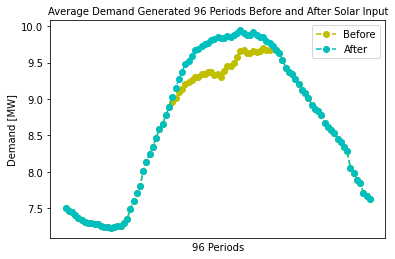

In [11]:
#Project #3 Energy Portfolio Management for Sustainable Campus
#Anna Nefedenkova, Rushabh Pathak, Kyann Hadife

import numpy as np
import pandas as pd
import datetime
import openpyxl
import scipy as sci
from pathlib import Path
import numpy as np
import math
import csv
from itertools import islice
from google.colab import files 
import matplotlib.pyplot as plt
from google.colab import drive
from re import I
import cvxpy as cp

#connect the drive, all files have to be stored in the person's personal drive with correct paths in order to run
drive.mount('/content/drive')

#upload all 5 scenario data 
source1 = '/content/drive/MyDrive/ESEOProject/Scenario1.csv'
scen1 = pd.read_csv(source1)

source2 = '/content/drive/MyDrive/ESEOProject/Scenario2.csv'
scen2 = pd.read_csv(source2)

source3 = '/content/drive/MyDrive/ESEOProject/Scenario3.csv'
scen3 = pd.read_csv(source3)

source4 = '/content/drive/MyDrive/ESEOProject/Scenario4.csv'
scen4 = pd.read_csv(source4)

source5 = '/content/drive/MyDrive/ESEOProject/Scenario5.csv'
scen5 = pd.read_csv(source5)

#create arrays to store the data extracted from the csv files
#and extract the data
#the demand is the only variable that is needed to be converted from KW to MW
periods = np.arange(0,95)
dem1 = []
wind1 = []
solar1 = []
realtime1 = [] 
windmax1 = []

with open(source1,'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in islice(lines,1,6000):
        dem1.append(float(row[1])/1000)
        wind1.append(float(row[2]))
        solar1.append(float(row[3]))
        realtime1.append(float(row[4]))

dem2 = []
wind2 = []
solar2 = []
realtime2 = [] 
windmax2 = []

with open(source2,'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in islice(lines,1,6000):
        dem2.append(float(row[1])/1000)
        wind2.append(float(row[2]))
        solar2.append(float(row[3]))
        realtime2.append(float(row[4]))

dem3 = []
wind3 = []
solar3 = []
realtime3 = [] 
windmax3 = []

with open(source3,'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in islice(lines,1,6000):
        dem3.append(float(row[1])/1000)
        wind3.append(float(row[2]))
        solar3.append(float(row[3]))
        realtime3.append(float(row[4]))

dem4 = []
wind4 = []
solar4 = []
realtime4 = [] 
windmax4 = []

with open(source4,'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in islice(lines,1,6000):
        dem4.append(float(row[1])/1000)
        wind4.append(float(row[2]))
        solar4.append(float(row[3]))
        realtime4.append(float(row[4]))

dem5 = []
wind5 = []
solar5 = []
realtime5 = [] 
windmax5 = []

with open(source5,'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in islice(lines,1,6000):
        dem5.append(float(row[1])/1000)
        wind5.append(float(row[2]))
        solar5.append(float(row[3]))
        realtime5.append(float(row[4]))

#for each scenario, additionally calculate the maximum wind capacity for each period
for i in range(0,95):
  value1 = 20 * (wind1[i])
  windmax1.append(value1)
  value2 = 20 * (wind2[i])
  windmax2.append(value2)
  value3 = 20 * (wind3[i])
  windmax3.append(value3)
  value4 = 20 * (wind4[i])
  windmax4.append(value4)
  value5 = 20 * (wind5[i])
  windmax5.append(value5)


initdemand = []
for i in range(0,95):
  demavev = (dem1[i] + dem2[i] + dem3[i] + dem4[i] + dem5[i]) / 5
  initdemand.append(demavev)

#we then substract the solar geneartion from the solar demand for each scenario 
for i in range(0,95):
  dem1[i] = dem1[i] - solar1[i]
  dem2[i] = dem2[i] - solar2[i] 
  dem3[i] = dem3[i] - solar3[i] 
  dem4[i] = dem4[i] - solar4[i] 
  dem5[i] = dem5[i] - solar5[i] 

demaftersolar = []
for i in range(0,95):
  demavev = (dem1[i] + dem2[i] + dem3[i] + dem4[i] + dem5[i]) / 5
  demaftersolar.append(demavev)

#plot graph comparing the inital demand and demand after solar energy substraction 
plt.plot(periods, demaftersolar, color = 'y', linestyle = 'dashed', marker = 'o', label = "Before")
plt.plot(periods, initdemand, color = 'c', linestyle = 'dashed', marker = 'o', label = "After")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Demand [MW]')
plt.title('Average Demand Generated 96 Periods Before and After Solar Input', fontsize = 10)
plt.legend()
plt.show()


# New Section

# Optimization

In [12]:
### OPTIMIZATIION ###

#Create the variables for the optimization, set them to only postive values, as we can not sell/have negative values of energy
WmwC = cp.Variable(nonneg = True) 
BGmwC = cp.Variable(nonneg = True)
PGmwC = cp.Variable(nonneg = True) 
#CGmwC = cp.Variable(nonneg = True)

MPmw1 = cp.Variable(nonneg = True) 
MPmw2 = cp.Variable(nonneg = True) 
MPmw3 = cp.Variable(nonneg = True) 
MPmw4 = cp.Variable(nonneg = True)  
MPmw5 = cp.Variable(nonneg = True)  

CGmw1 = cp.Variable(nonneg = True) 
CGmw2 = cp.Variable(nonneg = True) 
CGmw3 = cp.Variable(nonneg = True) 
CGmw4 = cp.Variable(nonneg = True)  
CGmw5 = cp.Variable(nonneg = True)  

#create the cost functions (variables) for wind, base generator, and peak generator
windPrice = 250 * WmwC 
base_gen = 15 * BGmwC 
peak_gen = 20 * PGmwC

#initilize arrays for the data to be stored 
windopt = []
baseopt = []
peakopt = []
contopt = []

MPopt1 = []
contopt1 = []
priceopt1 = []
costopt1 = []

MPopt2 = []
contopt2 = []
priceopt2 = []
costopt2 = []

MPopt3 = []
contopt3 = []
priceopt3 = []
costopt3 = []

MPopt4 = []
contopt4 = []
priceopt4 = []
costopt4 = []

MPopt5 = []
contopt5 = []
priceopt5 = []
costopt5 = []

costave = []
priceave = []
demave = []

# Storage represents a 2MW capacity power pack installed on campus

storage = cp.Variable(nonneg = True)

storage = 0
#the main loop where we optimize each period with all 5 scenarios at once 
#we optimize each period, as we want to make sure we get more exact numbers

for i in range(0,95):

  #we initilize our constrain array 
  cont = []
  
  #we ensure we devide the market price by 4 in order to keepthe propotinally of the price to the period (1/4 of an hour)
  #our market price and contract generator exercise fee are the only x variables in our minimation problem 
  #where the value to be optimized depends on each period
  #the if statement, allows us to set the problem where the market price of the contrain generator work hand in hand, 
  #we choose one or the other
  if (realtime1[i]/4 + (5/4) >= 18/4):
    cont_gen_x1 = CGmw1 * 18/4
    spot_mar1 = 0  
    cont += [MPmw1 == 0]
  else:
    cont_gen_x1 = 0 
    spot_mar1 = (realtime1[i]/4 + (5/4)) * MPmw1
    cont += [CGmw1 == 0]
  
  if (realtime2[i]/4 + (5/4) >= 18/4):
    cont_gen_x2 = CGmw2 * 18/4
    spot_mar2 = 0 
    cont += [MPmw2 == 0]
  else:
    cont_gen_x2 = 0 
    spot_mar2 = (realtime2[i]/4 + (5/4)) * MPmw2
    cont += [CGmw2 == 0]

  if (realtime3[i]/4 + (5/4) >= 18/4):
    cont_gen_x3 = CGmw3 * 18/4 
    spot_mar3 = 0 
    cont += [MPmw3 == 0]
  else:
    cont_gen_x3 = 0 
    spot_mar3 = (realtime3[i]/4 + (5/4)) * MPmw3
    cont += [CGmw3 == 0]

  if (realtime4[i]/4 + (5/4) >= 18/4):
    cont_gen_x4 = CGmw4 * 18/4
    spot_mar4 = 0 
    cont += [MPmw4 == 0]
  else:
    cont_gen_x4 = 0 
    spot_mar4 = (realtime4[i]/4 + (5/4)) * MPmw4
    cont += [CGmw4 == 0]

  if (realtime5[i]/4 + (5/4) >= 18/4):
    cont_gen_x5 = CGmw5 * 18/4
    spot_mar5 = 0 
    cont += [MPmw5 == 0]
  else:
    cont_gen_x5 = 0 
    spot_mar5 = (realtime5[i]/4 + (5/4)) * MPmw5
    cont += [CGmw5 == 0]

  #we add the constrain where our contract generation can not exceed more than 10MW
  cont += [(CGmw1 + CGmw2 + CGmw3+ CGmw4 + CGmw5)/5 + BGmwC + PGmwC <= 10];
  
  #we define our generator contract option fee 
  cont_gen = 50 * ((CGmw1 + CGmw2 + CGmw3+ CGmw4 + CGmw5)/5) 
  
  #we ensure and add a constrain so that our maximum generation (how much we exercise) of wind does 
  #not exceed the maximum possible generation from the wind for each period
  windave = (windmax1[i] + windmax2[i] + windmax3[i] + windmax4[i] + windmax5[i]) / 5
  cont += [WmwC <= windave];
  
  #we add a contrain for the time when we can exercise the peak generator
  if i in range(31,71):
    cont += [PGmwC <= 20];
  else:
    cont += [PGmwC == 0.00];
  
  #we add a constrain so the total production meets out demand for each period 
  demavev = (dem1[i] + dem2[i] + dem3[i] + dem4[i] + dem5[i]) / 5
  demave.append(demavev)
  cont += [WmwC + BGmwC + PGmwC + (CGmw1 + CGmw2 + CGmw3+ CGmw4 + CGmw5)/5 + (MPmw1 + MPmw2 + MPmw3 + MPmw4 + MPmw5)/5 == demavev]; 

  #initliaze our main function where we are optimizinf all the scearions with the equal probability
  obj = cp.Minimize(base_gen + peak_gen + cont_gen + windPrice + 
                   (cont_gen_x1 + spot_mar1)*0.2 +        
                   (cont_gen_x2 + spot_mar2)*0.2 + 
                   (cont_gen_x3 + spot_mar3)*0.2 + 
                   (cont_gen_x4 + spot_mar4)*0.2 + 
                   (cont_gen_x5 + spot_mar5)*0.2)


  #initialize the probelm with the five constrain
  prob = cp.Problem(obj, cont)
  prob.solve(verbose = False) 

  #we append all our computed values into the initialzied arrays at the beggining of the section, 
  #in order to later work with the values and plot graphs
  windopt.append(WmwC.value)
  baseopt.append(BGmwC.value)
  peakopt.append(PGmwC.value)
  
  MPopt1.append(MPmw1.value)
  contopt1.append(CGmw1.value)
  MPopt2.append(MPmw2.value)
  contopt2.append(CGmw2.value)
  MPopt3.append(MPmw3.value)
  contopt3.append(CGmw3.value)
  MPopt4.append(MPmw4.value)
  contopt4.append(CGmw4.value)
  MPopt5.append(MPmw5.value)
  contopt5.append(CGmw5.value)

  #we get our cost and price values and likewise store them in our respective arrays
  cost = prob.value
  price = -cont[8].dual_value
  costave.append(cost)
  priceave.append(price)
  
MPavet = []
contavet = []
#we get the average of the market price and contract generator average value for each period
for i in range(0,95):
  MPavev = (MPopt1[i] + MPopt2[i] + MPopt3[i] + MPopt4[i] + MPopt5[i])/5
  MPavet.append(MPavev)
  contavev = (contopt1[i] + contopt2[i] + contopt3[i] + contopt4[i] + contopt5[i])/5
  contavet.append(contavev)

#print the total averga sum for all 5 scenarios throughout the whole day 
print("sum:", sum(costave))

sum: 7523.223247680582


# Optimization Plots

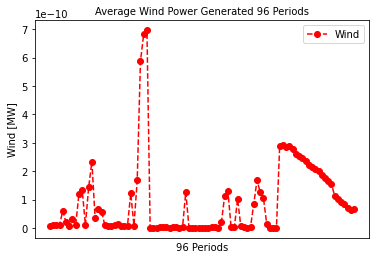

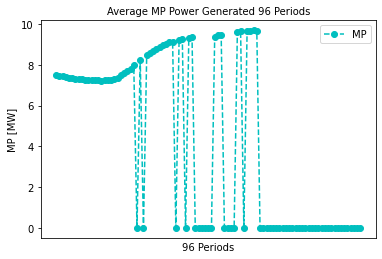

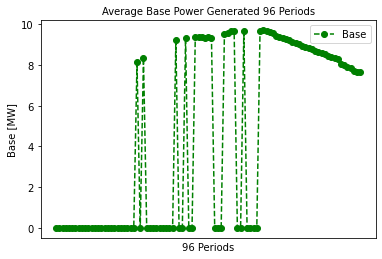

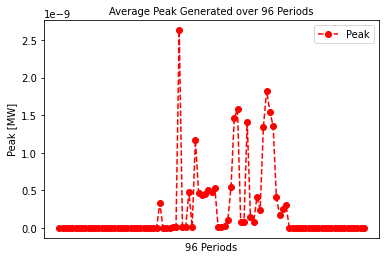

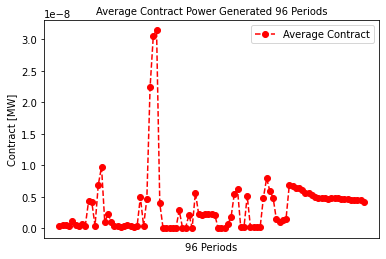

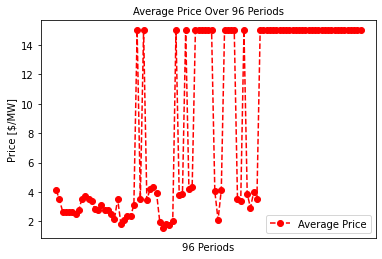

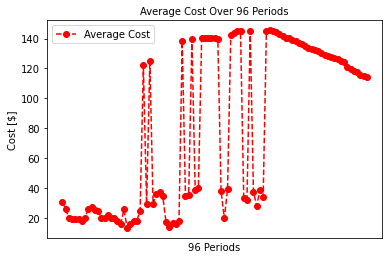

In [13]:
#plot all generated values into graphs for vizualization
plt.plot(periods, windopt, color = 'r', linestyle = 'dashed', marker = 'o', label = "Wind")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Wind [MW]')
plt.title('Average Wind Power Generated 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, MPavet, color = 'c', linestyle = 'dashed', marker = 'o', label = "MP")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('MP [MW]')
plt.title('Average MP Power Generated 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, baseopt, color = 'g', linestyle = 'dashed', marker = 'o', label = "Base")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Base [MW]')
plt.title('Average Base Power Generated 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, peakopt, color = 'r', linestyle = 'dashed', marker = 'o', label = "Peak")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Peak [MW]')
plt.title('Average Peak Generated over 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, contavet, color = 'r', linestyle = 'dashed', marker = 'o', label = "Average Contract")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Contract [MW]')
plt.title('Average Contract Power Generated 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, priceave, color = 'r', linestyle = 'dashed', marker = 'o', label = "Average Price")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Price [$/MW]')
plt.title('Average Price Over 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, costave, color = 'r', linestyle = 'dashed', marker = 'o', label = "Average Cost")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Cost [$]')
plt.title('Average Cost Over 96 Periods', fontsize = 10)
plt.legend()
plt.show()

# CVaR Optimization

In [14]:
### CVaR ###

##optmization probelm to minimize the loss (the risk)
#initiliaze the values for N and B
N = 5 #number of scenarios
B = 0.2 #taking the value of Beta as 0.2 (equal to the probability) in order to find the worst case scenario

#initialize the alpha variable 
alpha = cp.Variable(nonneg = False)

#initialize the variable for the problem, just like inthe previous section
WmwC = cp.Variable(nonneg = True) 
BGmwC = cp.Variable(nonneg = True)
PGmwC = cp.Variable(nonneg = True) 
#CGmwC = cp.Variable(nonneg = True)

MPmw1 = cp.Variable(nonneg = True) 
MPmw2 = cp.Variable(nonneg = True) 
MPmw3 = cp.Variable(nonneg = True) 
MPmw4 = cp.Variable(nonneg = True)  
MPmw5 = cp.Variable(nonneg = True)  

CGmw1 = cp.Variable(nonneg = True) 
CGmw2 = cp.Variable(nonneg = True) 
CGmw3 = cp.Variable(nonneg = True) 
CGmw4 = cp.Variable(nonneg = True)  
CGmw5 = cp.Variable(nonneg = True)  

#initialize the cost functions
windPrice = 250 * WmwC 
base_gen = 15 * BGmwC 
peak_gen = 20 * PGmwC

#initialize the arrays to store values as we loop through each period
windopt = []
baseopt = []
peakopt = []
contopt = []

MPopt1 = []
contopt1 = []
priceopt1 = []
costopt1 = []

MPopt2 = []
contopt2 = []
priceopt2 = []
costopt2 = []

MPopt3 = []
contopt3 = []
priceopt3 = []
costopt3 = []

MPopt4 = []
contopt4 = []
priceopt4 = []
costopt4 = []

MPopt5 = []
contopt5 = []
priceopt5 = []
costopt5 = []

lossave = []
priceave = []
demave = []

for i in range(0,95):
  
  #initilize the constrain array 
  cont = []

  #we ensure we devide the market price by 4 in order to keepthe propotinally of the price to the period (1/4 of an hour)
  #our market price and contract generator exercise fee are the only x variables in our minimation problem 
  #where the value to be optimized depends on each period
  #the if statement, allows us to set the problem where the market price of the contrain generator work hand in hand, 
  #we choose one or the other
  if (realtime1[i]/4 + (5/4) >= 18/4):
    cont_gen_x1 = CGmw1 * 18/4
    spot_mar1 = 0  
    cont += [MPmw1 == 0]
  else:
    cont_gen_x1 = 0 
    spot_mar1 = (realtime1[i]/4 + (5/4)) * MPmw1
    cont += [CGmw1 == 0]
  
  if (realtime2[i]/4 + (5/4) >= 18/4):
    cont_gen_x2 = CGmw2 * 18/4
    spot_mar2 = 0 
    cont += [MPmw2 == 0]
  else:
    cont_gen_x2 = 0 
    spot_mar2 = (realtime2[i]/4 + (5/4)) * MPmw2
    cont += [CGmw2 == 0]

  if (realtime3[i]/4 + (5/4) >= 18/4):
    cont_gen_x3 = CGmw3 * 18/4 
    spot_mar3 = 0 
    cont += [MPmw3 == 0]
  else:
    cont_gen_x3 = 0 
    spot_mar3 = (realtime3[i]/4 + (5/4)) * MPmw3
    cont += [CGmw3 == 0]

  if (realtime4[i]/4 + (5/4) >= 18/4):
    cont_gen_x4 = CGmw4 * 18/4
    spot_mar4 = 0 
    cont += [MPmw4 == 0]
  else:
    cont_gen_x4 = 0 
    spot_mar4 = (realtime4[i]/4 + (5/4)) * MPmw4
    cont += [CGmw4 == 0]

  if (realtime5[i]/4 + (5/4) >= 18/4):
    cont_gen_x5 = CGmw5 * 18/4
    spot_mar5 = 0 
    cont += [MPmw5 == 0]
  else:
    cont_gen_x5 = 0 
    spot_mar5 = (realtime5[i]/4 + (5/4)) * MPmw5
    cont += [CGmw5 == 0]

  #we add the constrain where our contract generation can not exceed more than 10MW
  cont += [(CGmw1 + CGmw2 + CGmw3+ CGmw4 + CGmw5)/5 + BGmwC + PGmwC <= 10];
  
  #we define our generator contract option fee 
  cont_gen = 50 * ((CGmw1 + CGmw2 + CGmw3+ CGmw4 + CGmw5)/5) 
  
  #we ensure and add a constrain so that our maximum generation (how much we exercise) of wind does 
  #not exceed the maximum possible generation from the wind for each period
  windave = (windmax1[i] + windmax2[i] + windmax3[i] + windmax4[i] + windmax5[i]) / 5
  cont += [WmwC <= windave];
  
  #we add a constrain for the time when we can exercise the peak generator
  if i in range(31,71):
    cont += [PGmwC <= 20];
  else:
    cont += [PGmwC == 0.00];
  
  #we add a constrain so the total production meets out demand for each period 
  demavev = (dem1[i] + dem2[i] + dem3[i] + dem4[i] + dem5[i]) / 5
  demave.append(demavev)
  cont += [WmwC + BGmwC + PGmwC + (CGmw1 + CGmw2 + CGmw3+ CGmw4 + CGmw5)/5 + (MPmw1 + MPmw2 + MPmw3 + MPmw4 + MPmw5)/5 == demavev]; 

  #we add a constrain to ensure the alpha value is greater than 0 and do not run into an issue of an unbound or infinite solution
  cont += [alpha >= 0]

  #we add a constrain to ensure that our M value is greater than 0 
  cont += [(base_gen + peak_gen + cont_gen + windPrice + 
                   (cont_gen_x1 + spot_mar1)*0.2 +        
                   (cont_gen_x2 + spot_mar2)*0.2 + 
                   (cont_gen_x3 + spot_mar3)*0.2 + 
                   (cont_gen_x4 + spot_mar4)*0.2 + 
                   (cont_gen_x5 + spot_mar5)*0.2) >= 0]

  #initliaze our main function where we are optimizinf all the scearions with the equal probability and fidning the minimal loss
  obj = cp.Minimize(alpha + ( 1 / (N * (1-B) )) * (base_gen + peak_gen + cont_gen + windPrice + 
                   (cont_gen_x1 + spot_mar1)*0.2 +        
                   (cont_gen_x2 + spot_mar2)*0.2 + 
                   (cont_gen_x3 + spot_mar3)*0.2 + 
                   (cont_gen_x4 + spot_mar4)*0.2 + 
                   (cont_gen_x5 + spot_mar5)*0.2))

  #we initialize the problem
  prob = cp.Problem(obj, cont)
  prob.solve(verbose = False) 
  
  #we append all our computed values into the initialzied arrays at the beggining of the section, 
  #in order to later work with the values and plot graphs
  windopt.append(WmwC.value)
  baseopt.append(BGmwC.value)
  peakopt.append(PGmwC.value)

  MPopt1.append(MPmw1.value)
  contopt1.append(CGmw1.value)
  MPopt2.append(MPmw2.value)
  contopt2.append(CGmw2.value)
  MPopt3.append(MPmw3.value)
  contopt3.append(CGmw3.value)
  MPopt4.append(MPmw4.value)
  contopt4.append(CGmw4.value)
  MPopt5.append(MPmw5.value)
  contopt5.append(CGmw5.value)

  #we get our loss and price values and likewise store them in our respective arrays
  loss = prob.value
  #print(cost)
  price = -cont[10].dual_value
  #print(price)
  lossave.append(loss)
  priceave.append(price)

MPavet = []
contavet = []

#we get the average of the market price and contract generator average value for each period
for i in range(0,95):
  MPavev = (MPopt1[i] + MPopt2[i] + MPopt3[i] + MPopt4[i] + MPopt5[i])/5
  MPavet.append(MPavev)
  contavev = (contopt1[i] + contopt2[i] + contopt3[i] + contopt4[i] + contopt5[i])/5
  contavet.append(contavev)

#print the total loss sum for all 5 scenarios throughout the whole day 
print("loss:", sum(lossave))

loss: 1880.8058083005812


# CVaR Optimization Plots

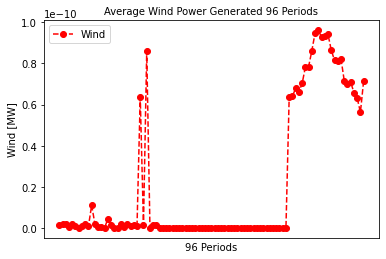

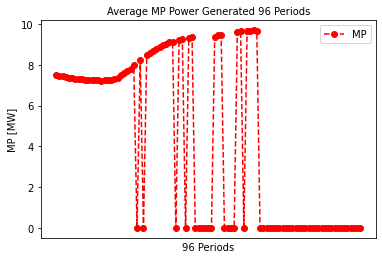

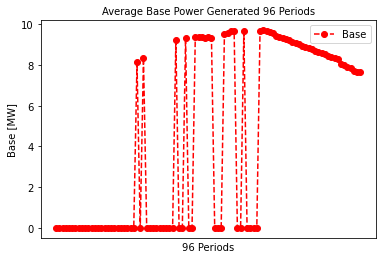

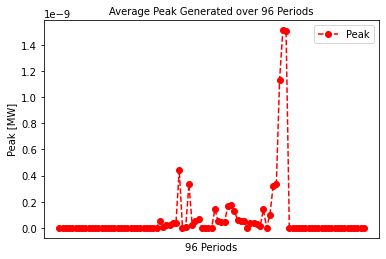

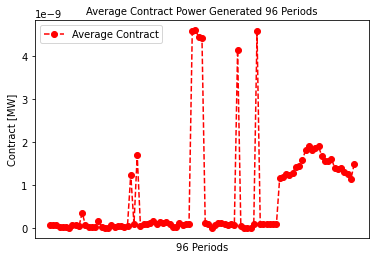

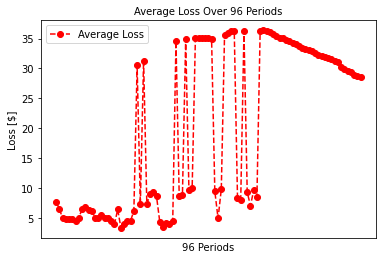

In [15]:
#plot all generated values into graphs for vizualization
plt.plot(periods, windopt, color = 'r', linestyle = 'dashed', marker = 'o', label = "Wind")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Wind [MW]')
plt.title('Average Wind Power Generated 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, MPavet, color = 'r', linestyle = 'dashed', marker = 'o', label = "MP")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('MP [MW]')
plt.title('Average MP Power Generated 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, baseopt, color = 'r', linestyle = 'dashed', marker = 'o', label = "Base")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Base [MW]')
plt.title('Average Base Power Generated 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, peakopt, color = 'r', linestyle = 'dashed', marker = 'o', label = "Peak")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Peak [MW]')
plt.title('Average Peak Generated over 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, contavet, color = 'r', linestyle = 'dashed', marker = 'o', label = "Average Contract")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Contract [MW]')
plt.title('Average Contract Power Generated 96 Periods', fontsize = 10)
plt.legend()
plt.show()

plt.plot(periods, lossave, color = 'r', linestyle = 'dashed', marker = 'o', label = "Average Loss")
plt.xticks([], [])
plt.xlabel('96 Periods')
plt.ylabel('Loss [$]')
plt.title('Average Loss Over 96 Periods', fontsize = 10)
plt.legend()
plt.show()